## Ryan 1991 v Atkin 2017 respiration models

Both respiration models run in fixed biogeography no competition mode. Results here are the last 5 years of a 300 year run. 

Leaf layer thickness parameters are 0.1 and 1.1. 

### Load libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize

import networkx as nx


### Plotting options

In [2]:
min_lat_plotting = -90
max_lat_plotting = 90
min_lon_plotting = -180
max_lon_plotting = 180
geog_range_plotting = [min_lon_plotting, max_lon_plotting, min_lat_plotting, max_lat_plotting]

pfts = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']


# colours for canopy/understory and FATES/Data
dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

### Functions

In [3]:
# Euclidean distance between each plot and grid cell midpoints 
# Should maybe account for curvature of the earth? Or maybe unimportant since we are using a 4x5 grid?
def get_euclidian_distance(x1,x2,y1,y2):
    dist = ( (abs(x1-x2))**2 + (abs(y1-y2))**2)**(1/2)
    return dist

def find_nearest_grid(lat,lon, mid_lats, mid_lons, fates_fracs):
    n_lat = len(mid_lats)
    n_lon = len(mid_lons)
    
    count = 0
    site_dists = np.empty((n_lat * n_lon))
    site_dists[:] = np.NaN
    min_index = np.empty((2))
    
    for i in range(0, n_lat):
        for j in range(0, n_lon):
       
            dist_ij = get_euclidian_distance(lat, mid_lats[i], lon, mid_lons[j])
            site_dists[count] = dist_ij
        
            if np.nanmin(site_dists) == dist_ij :
                if not np.isnan(fates_fracs[i,j]):
                    min_index[0] = i
                    min_index[1] = j
            
            count = count + 1
    return min_index


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


### Load FATES runs

In [4]:
# Default respiration model

# default leaf layer thickness
#fates_history_file_def = '/compyfs/need138/elm_runs/fixed_biog_nocomp_JH_abg_vars.Ec63cce2-F9f228fd.2022-10-26/run/lnd/hist/threehundred/fixed_biog_nocomp_JH_abg_vars.Ec63cce2-F9f228fd.2022-10-26.elm.h0.fullrun.nc'
# updated leaf layer thickness
fates_history_file_def = '/compyfs/need138/elm_runs/m20_ensemble_2.Ec63cce2-F612413c.m20_ensemble_2.2022-11-08/run/lnd/hist/m20_ensemble_2.Ec63cce2-F612413c.m20_ensemble_2.2022-11-08.elm.h0.fullrun.nc'
fates_def = xr.open_dataset(fates_history_file_def,  decode_times=False)
nyears = int(len(fates_def.variables['time'])/12)
n_lat = len(fates_def.variables['lat'])
n_lon = len(fates_def.variables['lon'])

tave_start = (nyears-5)*12
tave_stop = nyears*12

cohort_size_bins = fates_def.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

# NB fates coords are from -90 to 90 and 0 to 180

# New respiration model
# default leaf layer thickness
#fates_new = '/compyfs/need138/elm_runs/fixed_biog_nocomp_newrespmod.Ec63cce2-F612413c.2022-11-03/run/lnd/hist/fixed_biog_nocomp_newrespmod.Ec63cce2-F612413c.2022-11-03.elm.h0.fullrun.nc'

# updated leaf layer thickness
fates_new = '/compyfs/need138/elm_runs/fixed_biog_nocomp_atkin.Ec63cce2-F612413c.2022-11-08/run/lnd/hist/fixed_biog_nocomp_atkin.Ec63cce2-F612413c.2022-11-08.elm.h0.fullrun.nc'
fates_new = xr.open_dataset(fates_new, decode_times=False)


### NPP, GPP and NPP/GPP 

''

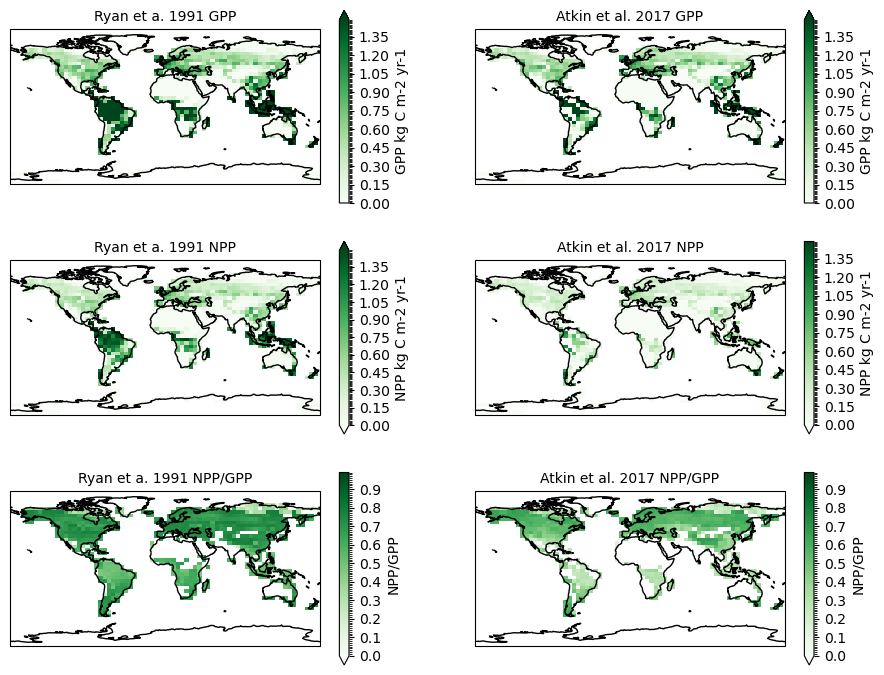

In [5]:
gpp_def = fates_def.FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
npp_def = fates_def.FATES_NPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
npp_gpp_def  = npp_def/gpp_def

gpp_new = fates_new.FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
npp_new = fates_new.FATES_NPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
npp_gpp_new  = npp_new/gpp_new


fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

clevs = np.arange(0.,1.5,0.01)
axs=axs.flatten()

gpp_def.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "GPP kg C m-2 yr-1"}, ax=axs[0])
axs[0].coastlines()
axs[0].set_title('Ryan et a. 1991 GPP', fontsize=10)

gpp_new.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "GPP kg C m-2 yr-1"}, ax=axs[1])
axs[1].coastlines()
axs[1].set_title('Atkin et al. 2017 GPP', fontsize=10)

npp_def.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "NPP kg C m-2 yr-1"}, ax=axs[2])
axs[2].coastlines()
axs[2].set_title('Ryan et a. 1991 NPP', fontsize=10)

npp_new.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "NPP kg C m-2 yr-1"}, ax=axs[3])
axs[3].coastlines()
axs[3].set_title('Atkin et al. 2017 NPP', fontsize=10)

clevs = np.arange(0.,1.0,0.01)
npp_gpp_def.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "NPP/GPP"}, ax=axs[4])
axs[4].coastlines()
axs[4].set_title('Ryan et a. 1991 NPP/GPP', fontsize=10)

npp_gpp_new.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "NPP/GPP"}, ax=axs[5])
axs[5].coastlines()
axs[5].set_title('Atkin et al. 2017 NPP/GPP', fontsize=10)




;

### Biomass by pft - Ryan  et al. 1991

''

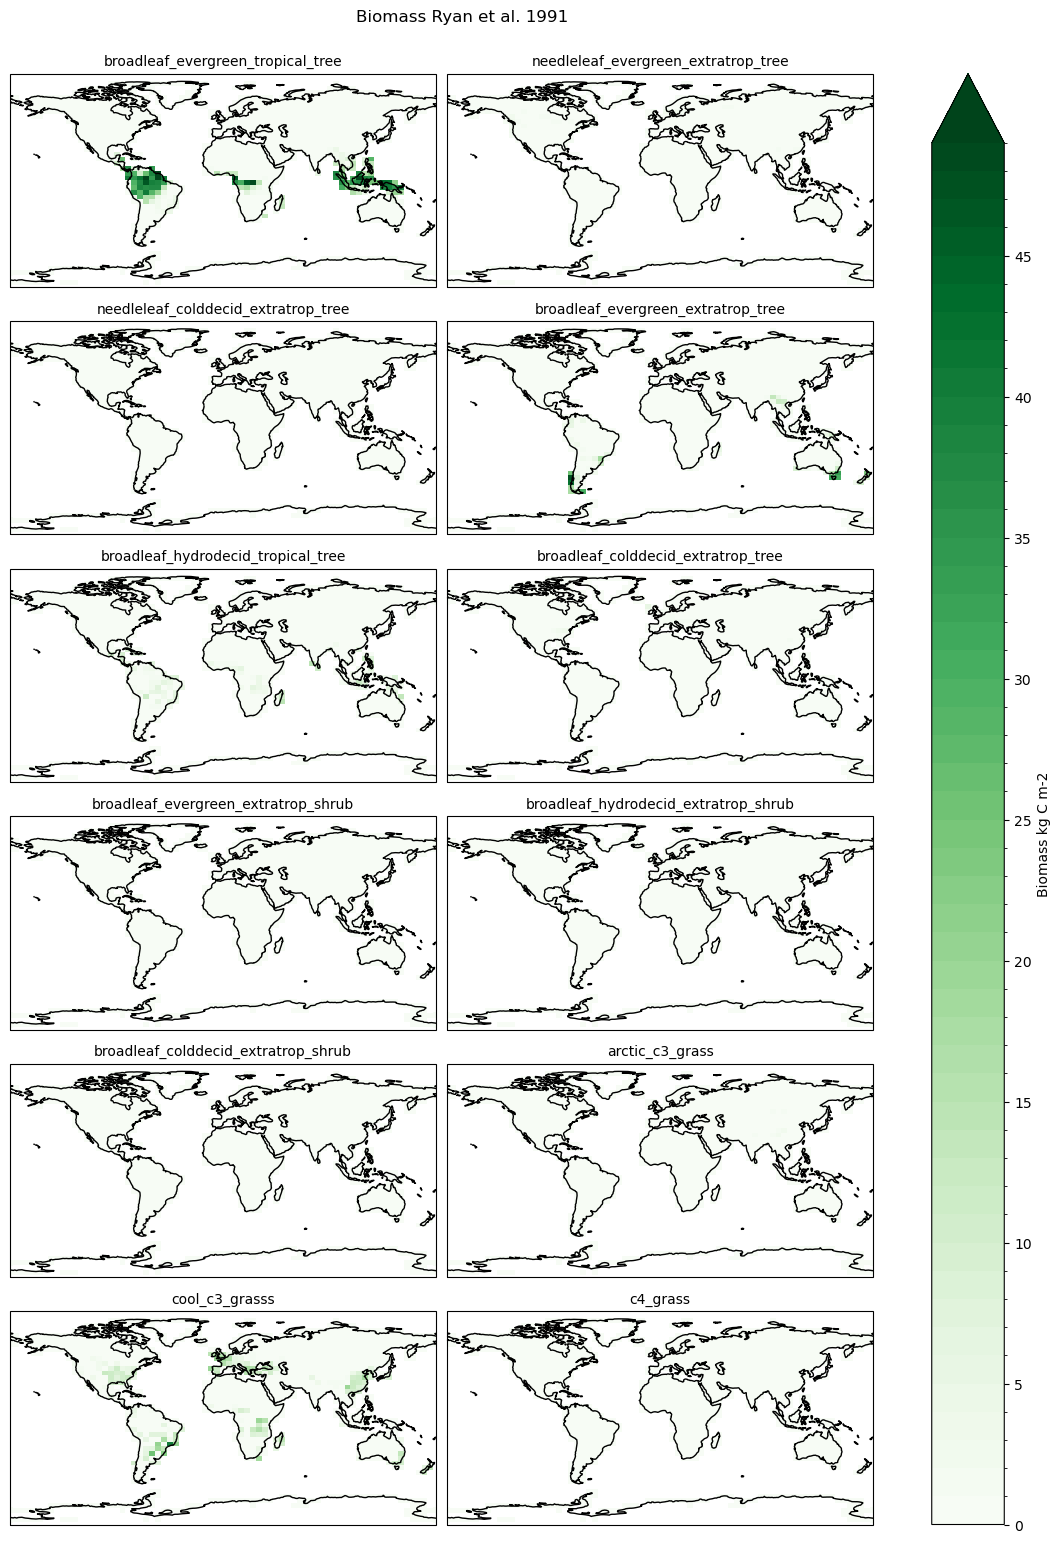

In [6]:
default = fates_def.FATES_VEGC_PF.isel(time=slice(tave_start,tave_stop)).mean(dim='time') 

g = default.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Biomass kg C m-2"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,50,1), cmap='Greens',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pfts[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Biomass Ryan et al. 1991', y=1.02, x = 0.45)
;

### Biomass by pft - Atkin et al. 2017

''

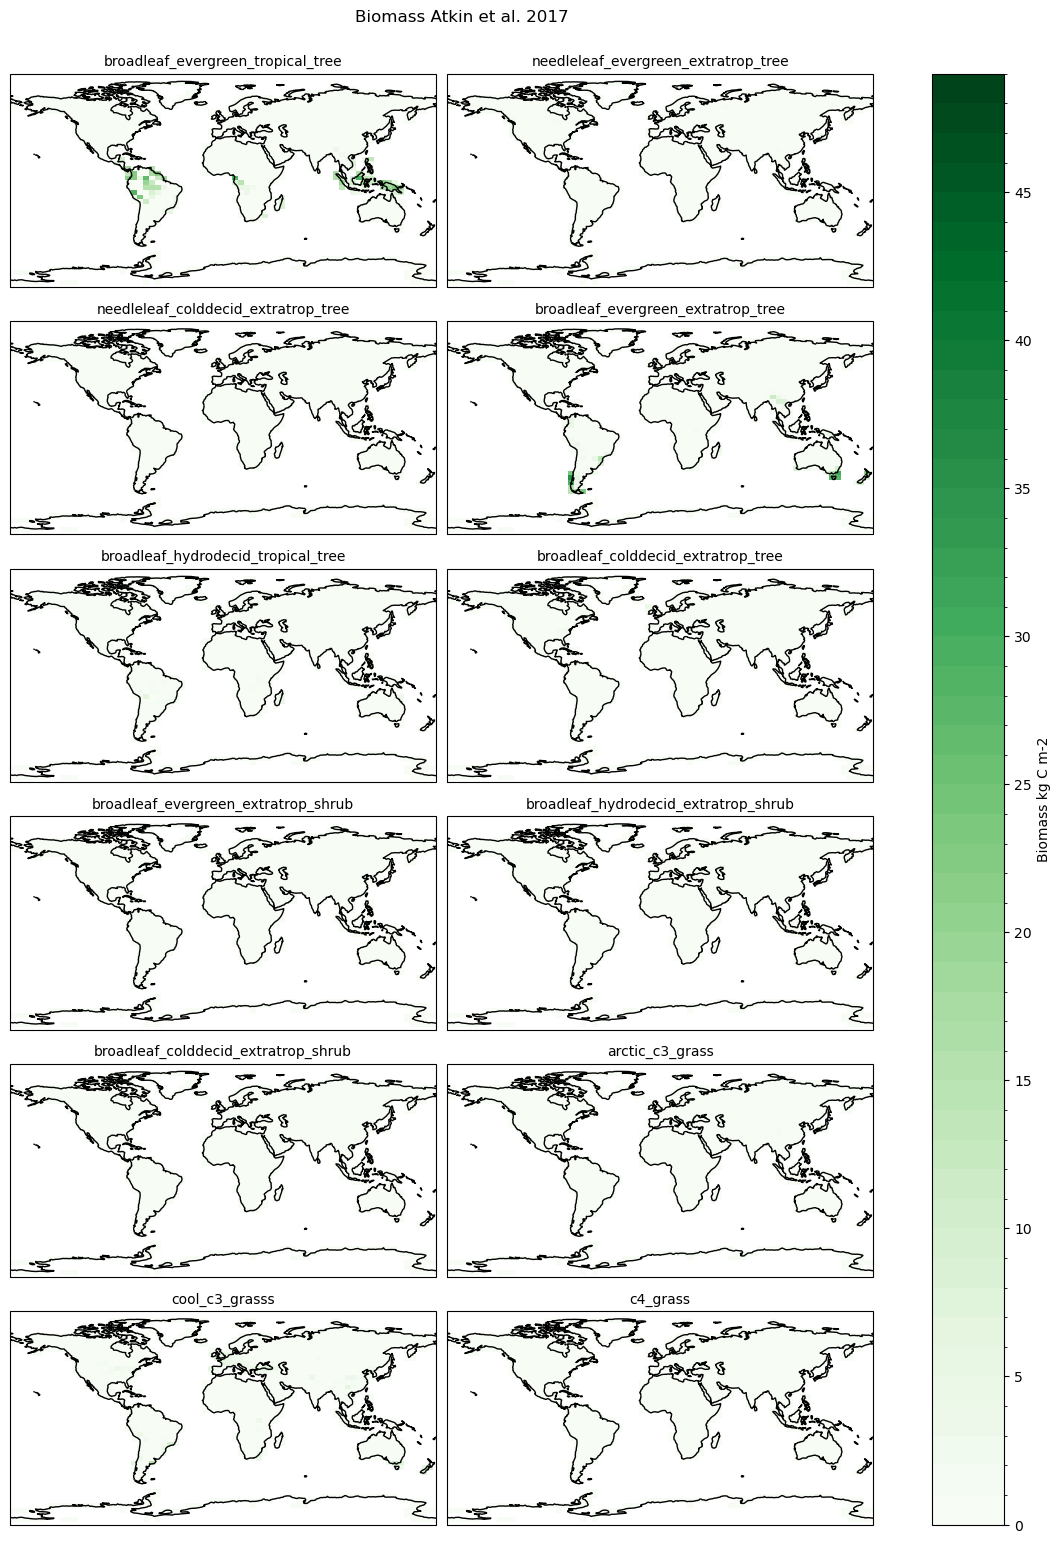

In [7]:
new = fates_new.FATES_VEGC_PF.isel(time=slice(tave_start,tave_stop)).mean(dim='time') 

g = new.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Biomass kg C m-2"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,50,1), cmap='Greens',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pfts[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Biomass Atkin et al. 2017', y=1.02, x = 0.45)
;

### NPP by pft - Ryan et al. 1991

''

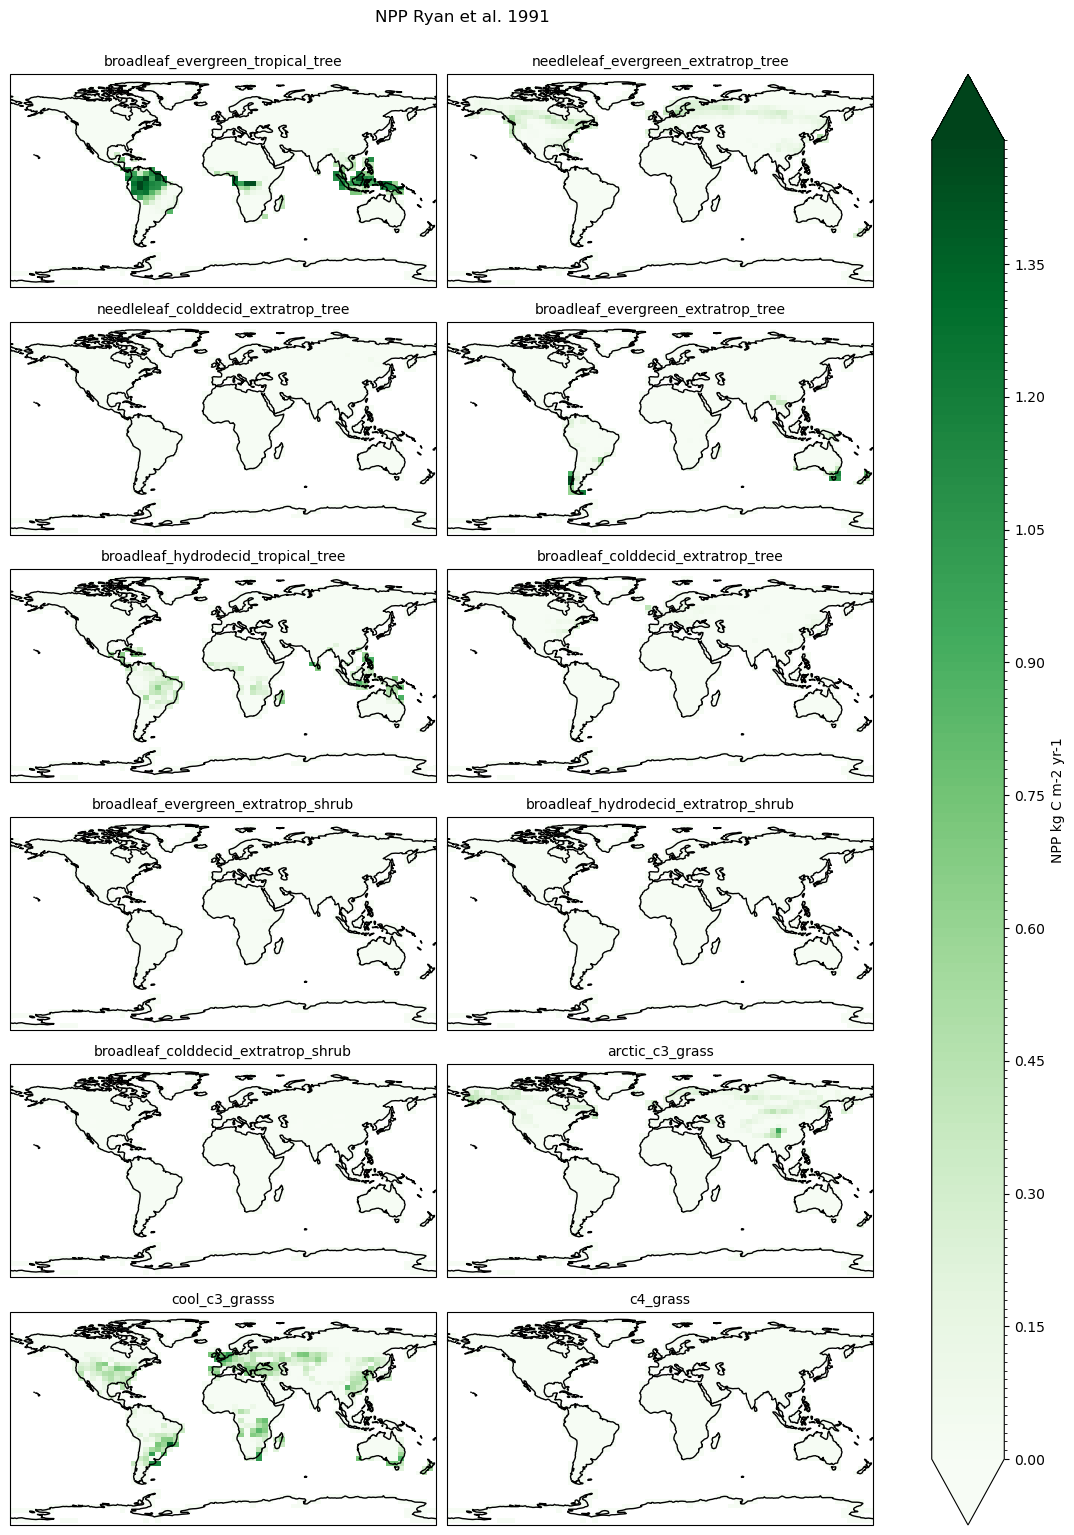

In [8]:
default = fates_def.FATES_NPP_PF.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365 

g = default.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "NPP kg C m-2 yr-1"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,1.5,0.01), cmap='Greens',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pfts[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('NPP Ryan et al. 1991', y=1.02, x = 0.45)
;

### NPP by pft - Atkin et al. 2017

''

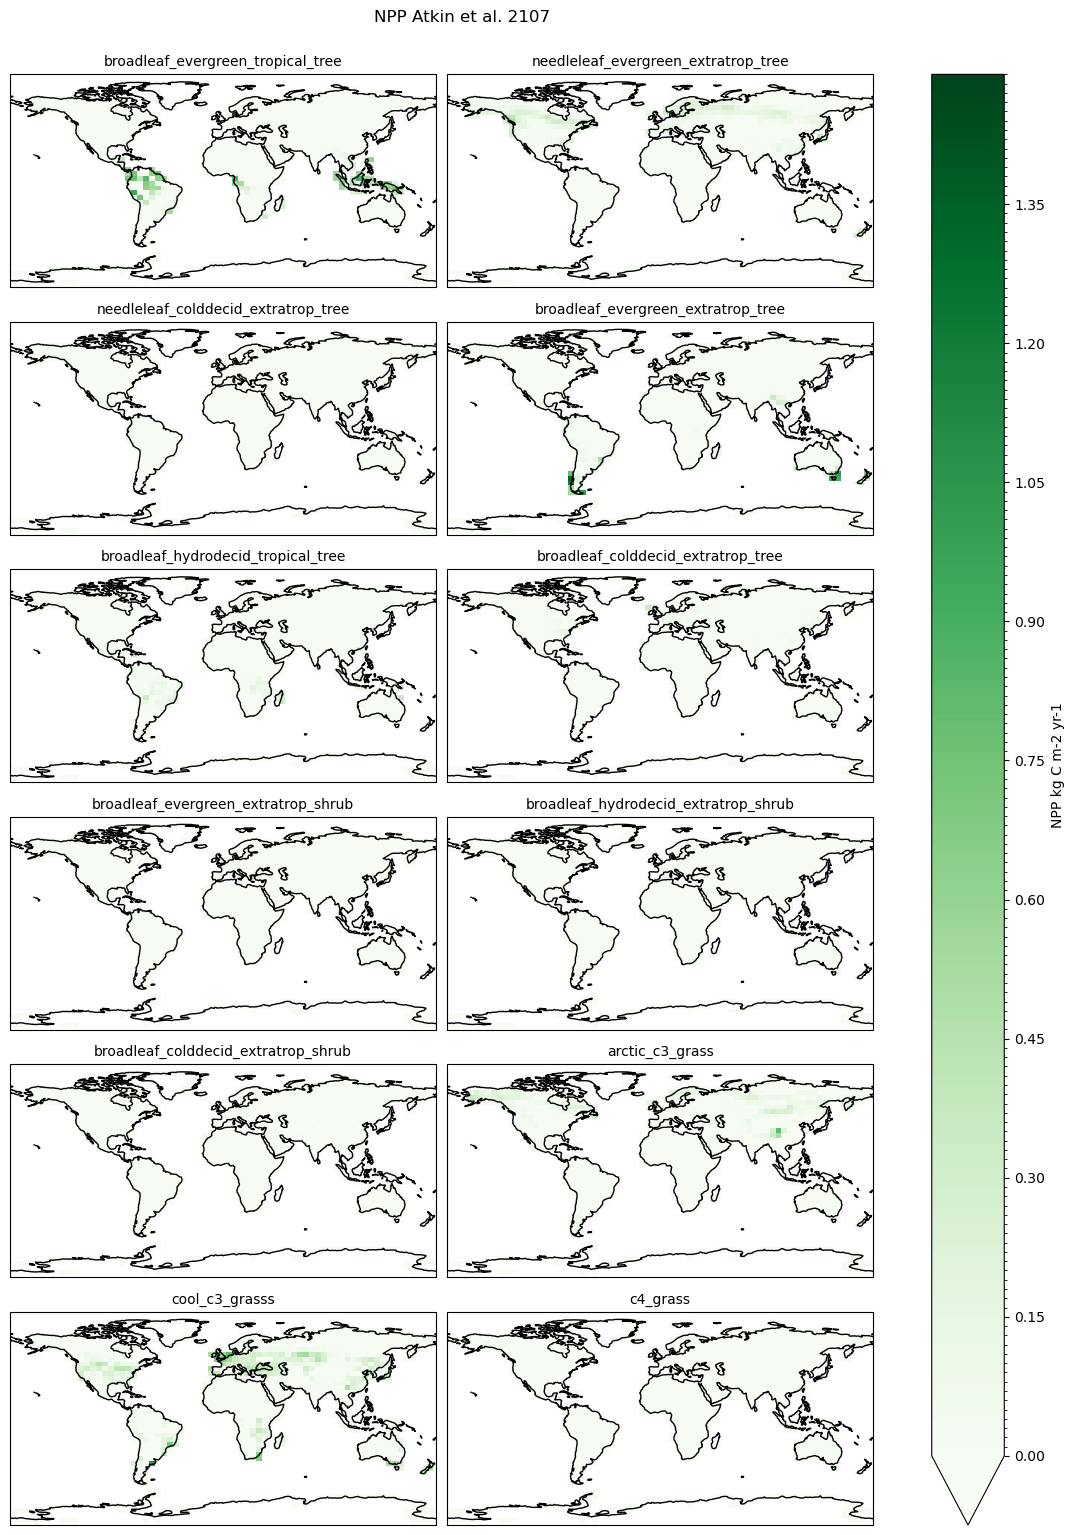

In [9]:
new = fates_new.FATES_NPP_PF.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365 

g = new.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "NPP kg C m-2 yr-1"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(0,1.5,0.01), cmap='Greens',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pfts[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('NPP Atkin et al. 2107', y=1.02, x = 0.45)
;

### Now compare totals from Galbraith 

In [10]:
df = pd.read_csv('/qfs/people/need138/plot_data/Galbraith_etal_2013_table_S1.csv')
#df.head(5)

# for plots with the same lat and lon use the mean of AGB, AWP and Tau
df['mean_AGB'] = df.groupby(['Lat','Lon'])['AGB (MgDM)'].transform('mean')
df['mean_AWP'] = df.groupby(['Lat','Lon'])['AWP (Mg DM year-1)'].transform('mean')
df['mean_tau'] = df.groupby(['Lat','Lon'])['Residence Time (years)'].transform('mean')

df = df.drop_duplicates(subset = ['Lat','Lon','mean_AGB'], keep = 'last').reset_index(drop=True)


lat = np.array(df['Lat'])
lon_negs = np.array(df['Lon'])
lon = [x%360 for x in lon_negs]


# AGB
plot_agb = np.array(df['mean_AGB'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_agb = plot_agb * 1000 / 10000 / 2 

# AWP
plot_awp = np.array(df['mean_AWP'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awp = plot_awp * 1000 / 10000 / 2 

# tau
plot_tau = np.array(df['mean_tau'])


#### Find closest grid cells

In [11]:
# Mid points of each grid cell
range_lat = 180
range_lon = 360
width_lat = range_lat/n_lat
width_lon = range_lon/n_lon
min_lat = fates_def.coords['lat'][0]
min_lon = fates_def.coords['lon'][0]
min_mid_lat = min_lat + width_lat/2
min_mid_lon = min_lon + width_lon/2

mid_lat = min_mid_lat.values + (width_lat * np.arange(n_lat))
mid_lon = min_mid_lon.values + (width_lon * np.arange(n_lon))

# Check fates frac in the selected grid cell. If it is NA then pick the next nearest grid cell. 
fates_frac = fates_def.FATES_FRACTION.isel(time=0).values

n_plots=len(lat) # number of forestGEO sites
min_grids = np.empty((n_plots,2),int) # array to hold index of nearest grid cells for each plot

for k in range(0, n_plots) :
    min_grids[k,:] = find_nearest_grid(lat[k], lon[k], mid_lat, mid_lon, fates_frac)
    
# get indeces
lat_ind = min_grids[:,0]
lon_ind = min_grids[:,1]
    
# These are on a -90 to 90 and 0 to 360 scale
plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

# Transform back to -90 to 90 and -180 to 180 for plotting
fig_plot_mid_lats = plot_mid_lats
fig_plot_mid_lons = [-1*(360-x) if x > 180 else x for x in plot_mid_lons]

In [12]:
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])

# AGB - total
agb_def = fates_def.FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
fates_agb_def = agb_def.isel(lat=x,lon=y)

# AWP - total
awp_def = fates_def.FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awp_def = awp_def = awp_def.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awp_def = awp_def.isel(lat=x,lon=y)

# Tau - total
fates_tau_def = fates_agb_def/fates_awp_def

# AGB - total
agb_new = fates_new.FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
fates_agb_new = agb_new.isel(lat=x,lon=y)

# AWP - total
awp_new = fates_new.FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awp_new = awp_new = awp_new.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awp_new = awp_new.isel(lat=x,lon=y)

# Tau - total
fates_tau_new = fates_agb_new/fates_awp_new



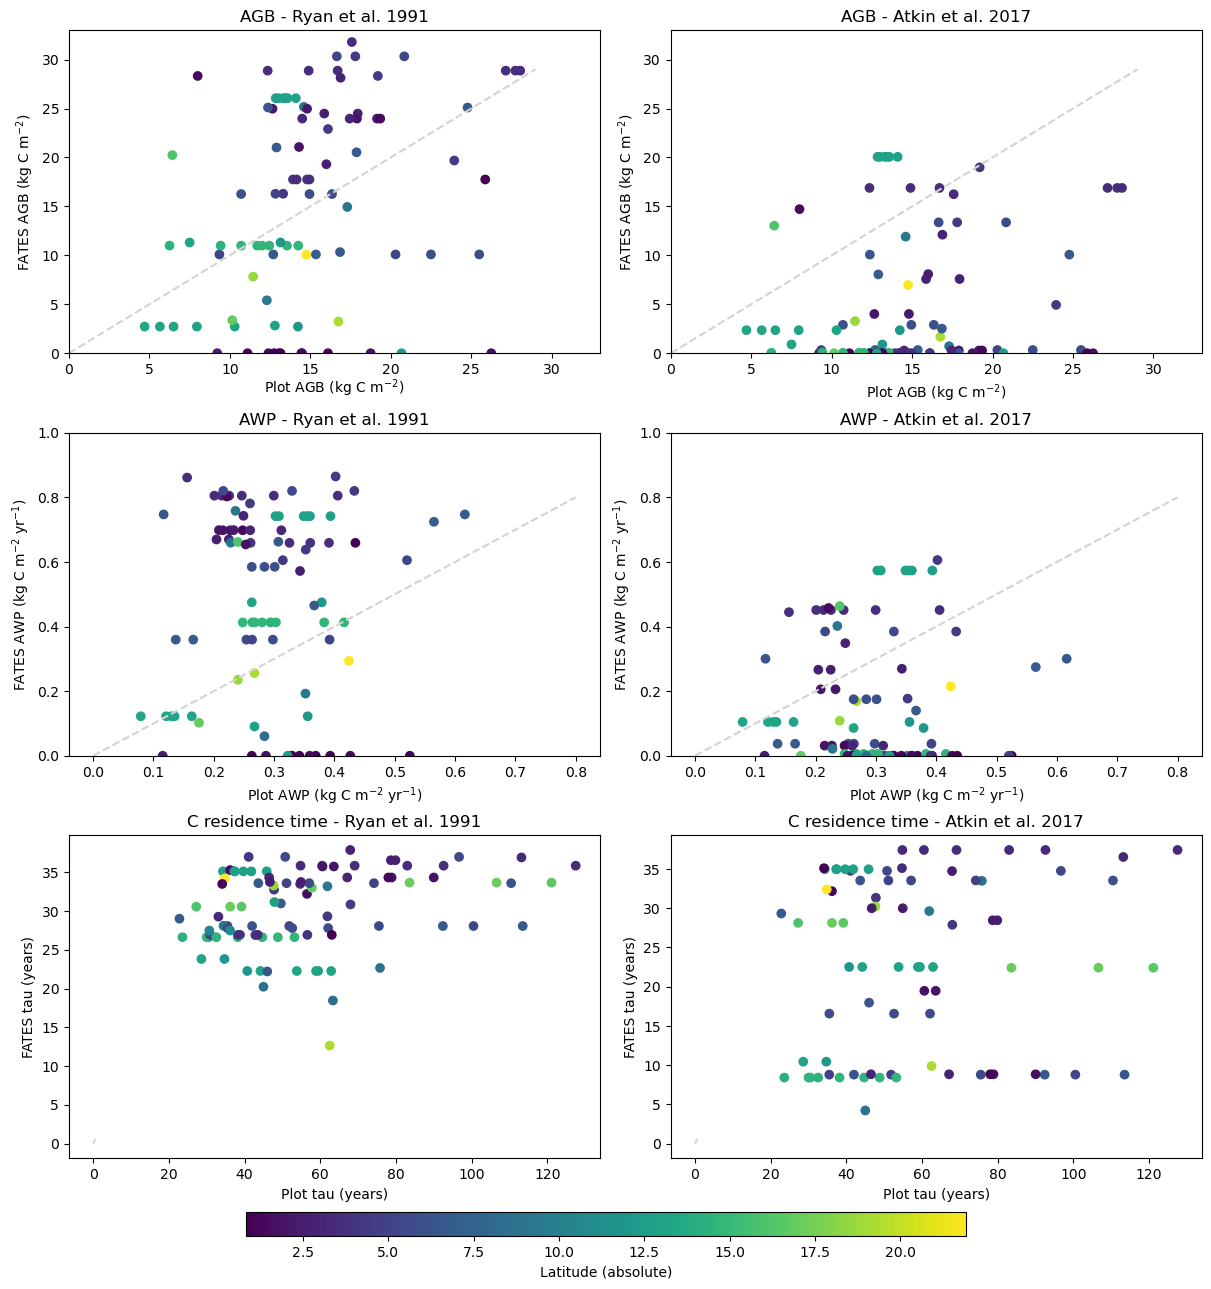

In [13]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3),(f2ax4,f2ax5)) = plt.subplots(nrows=3,ncols=2, figsize=(12,12),
                                                                 constrained_layout=True)

# AGB 
# colour coded by latitude
f2ax0.scatter(plot_agb, fates_agb_def, c=abs(lat))
f2ax0.set_title(r'AGB - Ryan et al. 1991', fontsize = 12)
f2ax0.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax0.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10, labelpad=0)
f2ax0.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax0.tick_params(labelsize=10)
f2ax0.set_ylim(0,33)
f2ax0.set_xlim(0,33)

f2ax1.scatter(plot_agb, fates_agb_new, c=abs(lat))
f2ax1.set_title(r'AGB - Atkin et al. 2017', fontsize = 12)
f2ax1.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax1.tick_params(labelsize=10)
f2ax1.set_ylim(0,33)
f2ax1.set_xlim(0,33)

# AWP 
f2ax2.scatter(plot_awp, fates_awp_def, c=abs(lat), cmap='viridis')
f2ax2.set_title(r'AWP - Ryan et al. 1991', fontsize = 12)
f2ax2.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax2.tick_params(labelsize=10)
f2ax2.set_ylim(0,1)

# AWP 
f2ax3.scatter(plot_awp, fates_awp_new, c=abs(lat), cmap='viridis')
f2ax3.set_title(r'AWP - Atkin et al. 2017', fontsize = 12)
f2ax3.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax3.tick_params(labelsize=10)
f2ax3.set_ylim(0,1)


# Tau
f2ax4.scatter(plot_tau, fates_tau_def, c=abs(lat), cmap='viridis')
f2ax4.set_title(r'C residence time - Ryan et al. 1991', fontsize = 12)
f2ax4.set_ylabel(r'FATES tau (years)', fontsize = 10)
f2ax4.set_xlabel(r'Plot tau (years)', fontsize = 10)
f2ax4.plot(np.linspace(0,0.6,10), np.linspace(0,0.6,10), color = 'lightgrey', linestyle='dashed')
f2ax4.tick_params(labelsize=10)

# AWM
sc = f2ax5.scatter(plot_tau, fates_tau_new, c=abs(lat), cmap='viridis')
f2ax5.set_title(r'C residence time - Atkin et al. 2017', fontsize = 12)
f2ax5.set_ylabel(r'FATES tau (years)', fontsize = 10)
f2ax5.set_xlabel(r'Plot tau (years)', fontsize = 10)
f2ax5.plot(np.linspace(0,0.6,10), np.linspace(0,0.6,10), color = 'lightgrey', linestyle='dashed')
f2ax5.tick_params(labelsize=10)

# Adjust the location of the subplots on the page to make room for the colorbar
#fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
 #                   wspace=0.02, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig2.add_axes([0.2, -0.025, 0.6, 0.02])

# Draw the colorbar
cbar=fig2.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Latitude (absolute)', fontsize=10)

### Load Piponiot et  al. totals 

In [14]:
total_data = pd.read_csv('/qfs/people/need138/plot_data/Piponiot_2022_totals.csv')
total_data =  total_data[total_data.Site != 'Laupahoehoe']
total_data =  total_data[total_data.Site != 'Palamanui']

sites = np.array(total_data['Site'])
lat = np.array(total_data['Lat'])
lon_negs = np.array(total_data['Lon'])
lon = [x%360 for x in lon_negs]


#### Extract grid cells corresponding to ForestGEO sites

In [15]:

n_plots=len(lat) # number of forestGEO sites
min_grids = np.empty((n_plots,2),int) # array to hold index of nearest grid cells for each plot


# Find  grid cell closest to each ForestGEO  plot
for k in range(0, n_plots) :
    min_grids[k,:] = find_nearest_grid(lat[k], lon[k], mid_lat, mid_lon, fates_frac)
    
# get indeces
lat_ind = min_grids[:,0]
lon_ind = min_grids[:,1]
    
# These are on a -90 to 90 and 0 to 360 scale
plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

# Transform back to -90 to 90 and -180 to 180 for plotting
fig_plot_mid_lats = plot_mid_lats
fig_plot_mid_lons = [-1*(360-x) if x > 180 else x for x in plot_mid_lons]


#### FATES 

In [16]:
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])

# AGB - total
agb_def = fates_def.FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
fates_agb_def = agb_def.isel(lat=x,lon=y)

# AWP - total
awp_def = fates_def.FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awp_def = awp_def.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awp_def = awp_def.isel(lat=x,lon=y)

# AWM - total
awm_def = fates_def.FATES_ABOVEGROUND_MORT_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awm_def = awm_def.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awm_def = awm_def.isel(lat=x,lon=y)

# AGB - total new
agb_new = fates_new.FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
fates_agb_new = agb_new.isel(lat=x,lon=y)

# AWP - total new
awp_new = fates_new.FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awp_new = awp_new.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awp_new = awp_new.isel(lat=x,lon=y)

# AWM - total  new
awm_new = fates_new.FATES_ABOVEGROUND_MORT_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
awm_new = awm_new.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
fates_awm_new = awm_new.isel(lat=x,lon=y)


#### Plots

In [17]:
# AGB
plot_agb = np.array(total_data['AGB'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_agb = plot_agb * 1000 / 10000 / 2 
# uncertainties
plot_agb_l = np.array(total_data['AGB_l'])
plot_agb_l  = plot_agb_l * 1000 / 10000 / 2
plot_agb_l = plot_agb - plot_agb_l
plot_agb_u = np.array(total_data['AGB_u'])
plot_agb_u  = plot_agb_u * 1000 / 10000 / 2
plot_agb_u = plot_agb_u - plot_agb

# AWP
plot_awp = np.array(total_data['AWP'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awp = plot_awp * 1000 / 10000 / 2 
# uncertainties
plot_awp_l = np.array(total_data['AWP_l'])
plot_awp_l  = plot_awp_l * 1000 / 10000 / 2
plot_awp_l = plot_awp - plot_awp_l
plot_awp_u = np.array(total_data['AWP_u'])
plot_awp_u  = plot_awp_u * 1000 / 10000 / 2
plot_awp_u = plot_awp_u - plot_awp

# AWM
plot_awm = np.array(total_data['AWM'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awm = plot_awm * 1000 / 10000 / 2 
# uncertainties
plot_awm_l = np.array(total_data['AWM_l'])
plot_awm_l  = plot_awm_l * 1000 / 10000 / 2
plot_awm_l = plot_awm - plot_awm_l
plot_awm_u = np.array(total_data['AWM_u'])
plot_awm_u  = plot_awm_u * 1000 / 10000 / 2
plot_awm_u = plot_awm_u - plot_awm

#### Figures 

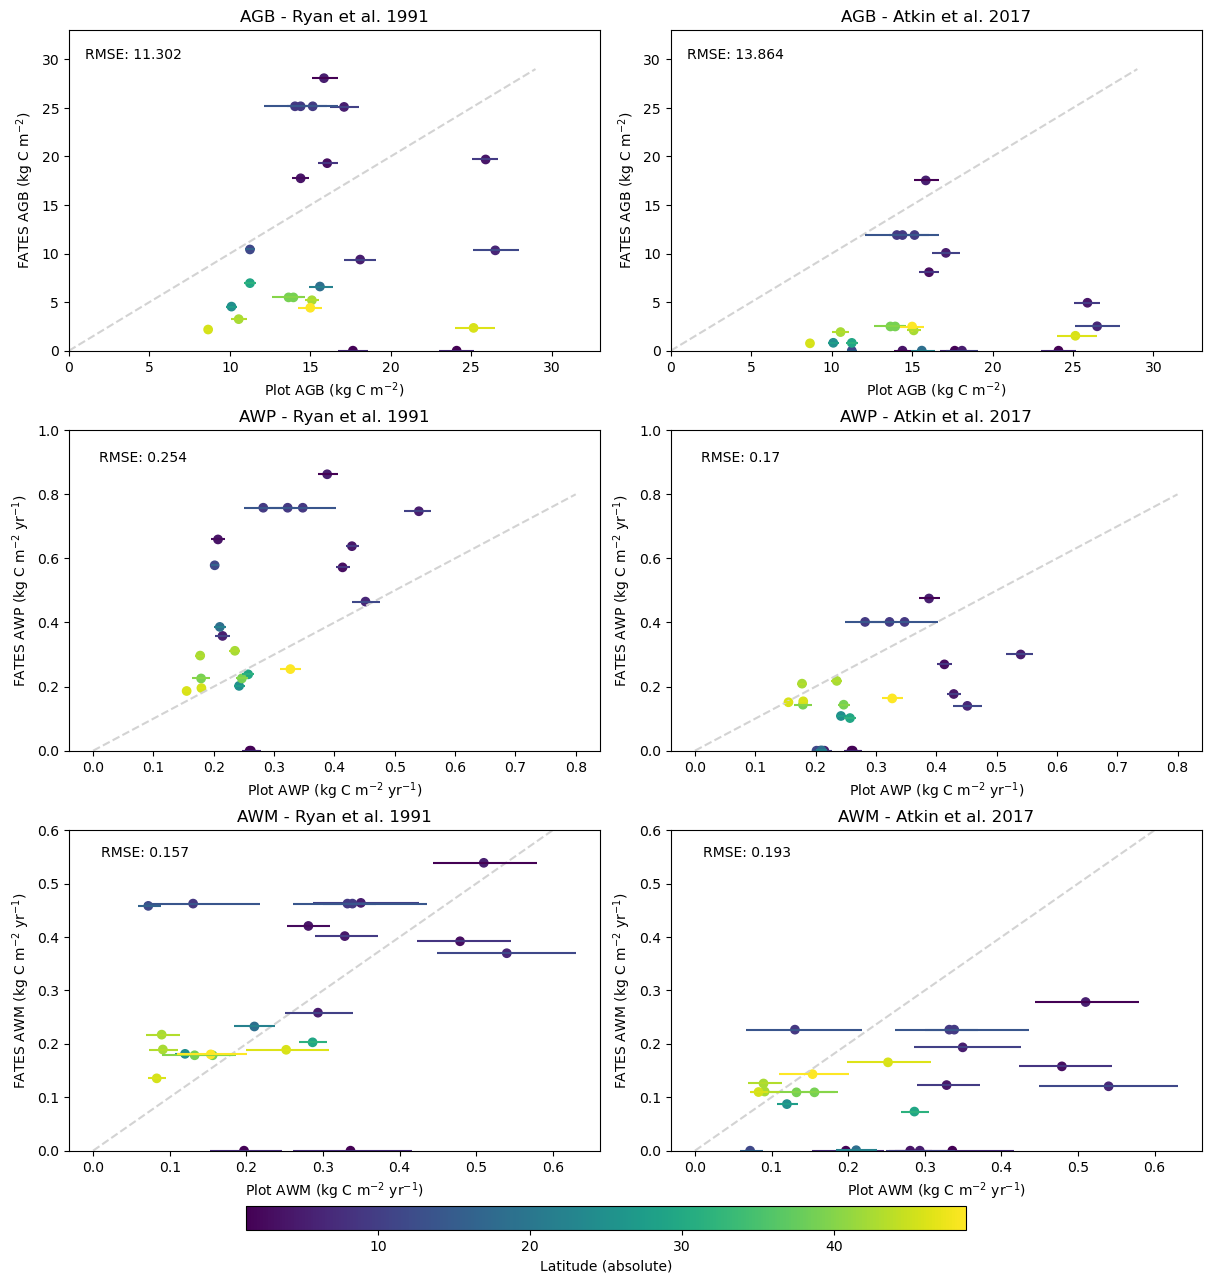

In [18]:
cc = lat
cmap=cm.viridis
norm=Normalize(vmin=cc.min(),vmax=cc.max())


fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3),(f2ax4,f2ax5)) = plt.subplots(nrows=3,ncols=2, figsize=(12,12),
                                                                 constrained_layout=True)

# AGB (without labels)
# colour coded by latitude
f2ax0.scatter(plot_agb, fates_agb_def, c=abs(lat))
f2ax0.set_title(r'AGB - Ryan et al. 1991', fontsize = 12)
f2ax0.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax0.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax0.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax0.tick_params(labelsize=10)
f2ax0.set_ylim(0,33)
f2ax0.set_xlim(0,33)
f2ax0.errorbar(plot_agb, fates_agb_def, xerr=[plot_agb_l, plot_agb_u],ecolor= cmap(norm(cc)), fmt='none')
root_mean_sq_err = rmse(fates_agb_def, plot_agb).values.round(3)
f2ax0.text(1, 30, 'RMSE: {}'.format(root_mean_sq_err), fontsize = 10)

f2ax1.scatter(plot_agb, fates_agb_new, c=abs(lat))
f2ax1.set_title(r'AGB - Atkin et al. 2017', fontsize = 12)
f2ax1.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax1.tick_params(labelsize=10)
f2ax1.set_ylim(0,33)
f2ax1.set_xlim(0,33)
f2ax1.errorbar(plot_agb, fates_agb_new, xerr=[plot_agb_l, plot_agb_u],ecolor= cmap(norm(cc)), fmt='none')
root_mean_sq_err = rmse(fates_agb_new, plot_agb).values.round(3)
f2ax1.text(1, 30, 'RMSE: {}'.format(root_mean_sq_err), fontsize = 10)

# AWP 
f2ax2.scatter(plot_awp, fates_awp_def, c=abs(lat), cmap='viridis')
f2ax2.set_title(r'AWP - Ryan et al. 1991', fontsize = 12)
f2ax2.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax2.tick_params(labelsize=10)
f2ax2.errorbar(plot_awp, fates_awp_def, xerr=[plot_awp_l, plot_awp_u],ecolor= cmap(norm(cc)), fmt='none')
f2ax2.set_ylim(0,1)
root_mean_sq_err = rmse(fates_awp_def, plot_awp).values.round(3)
f2ax2.text(0.01, 0.9, 'RMSE: {}'.format(root_mean_sq_err), fontsize = 10)

# AWP 
f2ax3.scatter(plot_awp, fates_awp_new, c=abs(lat), cmap='viridis')
f2ax3.set_title(r'AWP - Atkin et al. 2017', fontsize = 12)
f2ax3.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax3.tick_params(labelsize=10)
f2ax3.errorbar(plot_awp, fates_awp_new, xerr=[plot_awp_l, plot_awp_u],ecolor= cmap(norm(cc)), fmt='none')
f2ax3.set_ylim(0,1)
root_mean_sq_err = rmse(fates_awp_new, plot_awp).values.round(3)
f2ax3.text(0.01, 0.9, 'RMSE: {}'.format(root_mean_sq_err), fontsize = 10)

# AWM
f2ax4.scatter(plot_awm, fates_awm_def, c=abs(lat), cmap='viridis')
f2ax4.set_title(r'AWM - Ryan et al. 1991', fontsize = 12)
f2ax4.set_ylabel(r'FATES AWM (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax4.set_xlabel(r'Plot AWM (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax4.plot(np.linspace(0,0.6,10), np.linspace(0,0.6,10), color = 'lightgrey', linestyle='dashed')
f2ax4.tick_params(labelsize=10)
f2ax4.errorbar(plot_awm, fates_awm_def, xerr=[plot_awm_l, plot_awm_u],ecolor= cmap(norm(cc)), fmt='none')
f2ax4.set_ylim(0,0.6)
root_mean_sq_err = rmse(fates_awm_def, plot_awm).values.round(3)
f2ax4.text(0.01, 0.55, 'RMSE: {}'.format(root_mean_sq_err), fontsize = 10)


# AWM
sc = f2ax5.scatter(plot_awm, fates_awm_new, c=abs(lat), cmap='viridis')
f2ax5.set_title(r'AWM - Atkin et al. 2017', fontsize = 12)
f2ax5.set_ylabel(r'FATES AWM (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax5.set_xlabel(r'Plot AWM (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax5.plot(np.linspace(0,0.6,10), np.linspace(0,0.6,10), color = 'lightgrey', linestyle='dashed')
f2ax5.tick_params(labelsize=10)
f2ax5.errorbar(plot_awm, fates_awm_new, xerr=[plot_awm_l, plot_awm_u],ecolor= cmap(norm(cc)), fmt='none')
f2ax5.set_ylim(0,0.6)
root_mean_sq_err = rmse(fates_awm_new, plot_awm).values.round(3)
f2ax5.text(0.01, 0.55, 'RMSE: {}'.format(root_mean_sq_err),  fontsize = 10)



# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig2.add_axes([0.2, -0.02, 0.6, 0.02])

# Draw the colorbar
cbar=fig2.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Latitude (absolute)', fontsize=10)


#### Load Piponiot et al. AWP, AWM, and AGB by size

In [19]:
data = pd.read_csv('/qfs/people/need138/plot_data/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')

In [20]:
vr = cm.get_cmap('Paired', 12)
colormap = vr(range(12))


### AWP 

Text(0.02, 0.5, 'AWP (kg C m$^{-2}$ yr$^{-2}$)')

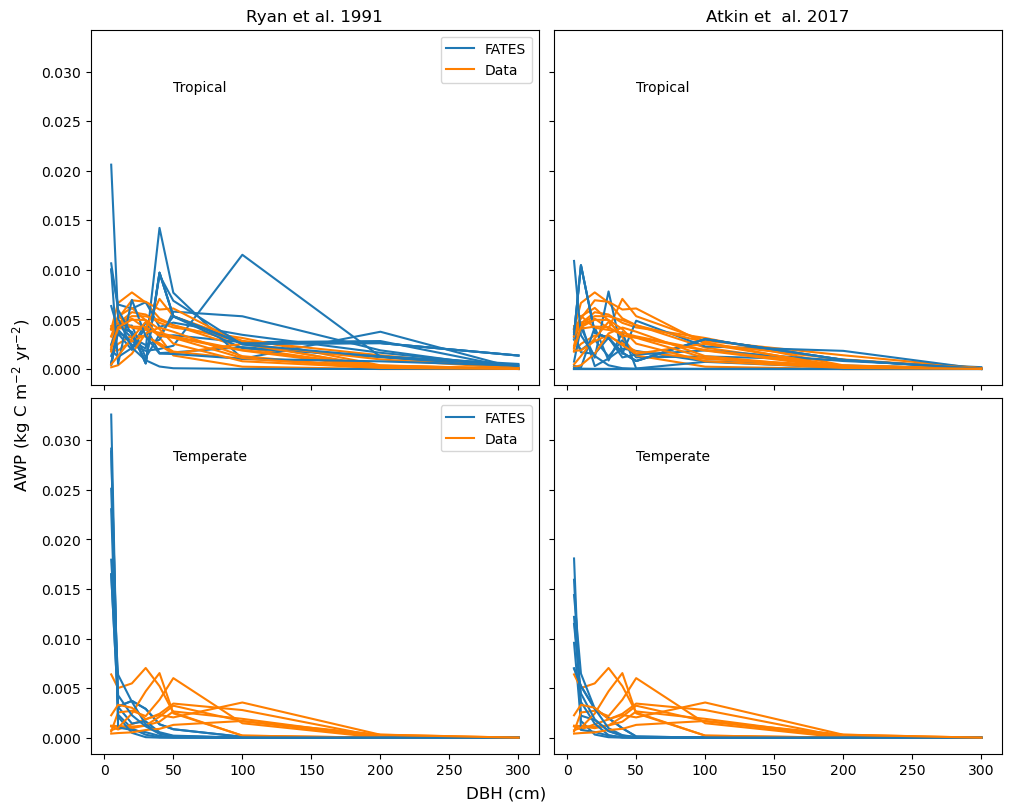

In [21]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(10,8),
                                                    constrained_layout=True, sharex=True, sharey=True)

tropical = ['Lenda','Edoro','Pasoh', 'Amacayacu', 'Lambir', 'Korup', 'Danum Valley', 'Wanang', 'Sinharaja', 'Cocoli',
           'BCI', 'San Lorenzo', 'Mudumalai', 'Luquillo', 'Fushan']
temperate = ['Gutianshan', 'SCBI', 'SERC', 'Changbaishan', 'MBW', 'Wabikon', 'Wind River', 'Zofin']

for s in range(2,n_plots) :
   
    name = sites[s]
 #   print(name)

    # Plots
    # just keep the site of interest
    plotdata = data[data['site'] == name]
    AWP = np.array(plotdata[plotdata["variable"] == 'AWP']['total'])
    # If some of the size classes are missing add zeros
    if (not len(AWP) == 9) :
        zeros = np.repeat(np.array([0]), [9 - len(AWP)], axis=0)
        AWP = np.append(AWP,zeros)
       
    # FATES
    # szpf to size by pft
    awp_sz_by_pft_def = fa.scpf_to_scls_by_pft(
        fates_def.FATES_ABOVEGROUND_PROD_SZPF, fates_def)*86400*365
    # sum over pfts
    awp_sz_def = awp_sz_by_pft_def.sum(dim='fates_levpft')
    # last five years and extract lat and lon
    awp_def = awp_sz_def.isel(lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time') 

    # szpf to size by pft
    awp_sz_by_pft_new = fa.scpf_to_scls_by_pft(
        fates_new.FATES_ABOVEGROUND_PROD_SZPF, fates_new)*86400*365
    # sum over pfts
    awp_sz_new = awp_sz_by_pft_new.sum(dim='fates_levpft')
    # last five years and extract lat and lon
    awp_new = awp_sz_new.isel(lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time') 

    
    cohort_size_bins_ex = np.append(cohort_size_bins[1:],300)
    bins = np.diff(cohort_size_bins_ex)
    fates_awp_def = np.squeeze(awp_def[1:,]) 
    fates_awp_def = fates_awp_def/bins
    fates_awp_new = np.squeeze(awp_new[1:,]) 
    fates_awp_new = fates_awp_new/bins

    if name in tropical : 
    
        ### AGW Productivity
        if name in tropical[10]:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_awp_def, color=colormap[1], label = 'FATES')
            f2ax0.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax0.set_title('Ryan et al. 1991')    
            f2ax0.text(50, 0.028, 'Tropical', fontsize=10)
            f2ax1.plot(cohort_size_bins_ex[1:], fates_awp_new, color=colormap[1], label = 'FATES')
            f2ax1.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax1.set_title('Atkin et  al. 2017')
            f2ax1.text(50, 0.028, 'Tropical', fontsize=10)
        else:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_awp_def, color=colormap[1])
            f2ax0.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color=colormap[7])
            f2ax1.plot(cohort_size_bins_ex[1:], fates_awp_new, color=colormap[1])
            f2ax1.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color=colormap[7])
        
        
    else : 
        ### AGW Productivity
        if name in temperate[1]:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_awp_def, color=colormap[1], label = 'FATES')
            f2ax2.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax2.text(50, 0.028, 'Temperate', fontsize=10)
            f2ax3.plot(cohort_size_bins_ex[1:], fates_awp_new, color=colormap[1], label = 'FATES')
            f2ax3.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax3.text(50, 0.028, 'Temperate', fontsize=10)
        else:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_awp_def, color=colormap[1])
            f2ax2.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7])
            f2ax3.plot(cohort_size_bins_ex[1:], fates_awp_new, color=colormap[1])
            f2ax3.plot(cohort_size_bins_ex[1:], AWP * 1000 / 10000 / 2 / bins, color = colormap[7])
        
f2ax0.legend(prop={'size':10})
f2ax2.legend(prop={'size':10})

fig2.supxlabel(r'DBH (cm)')
fig2.supylabel(r'AWP (kg C m$^{-2}$ yr$^{-2}$)')

### AWM

Text(0.02, 0.5, 'AWM (kg C m$^{-2}$ yr$^{-2}$)')

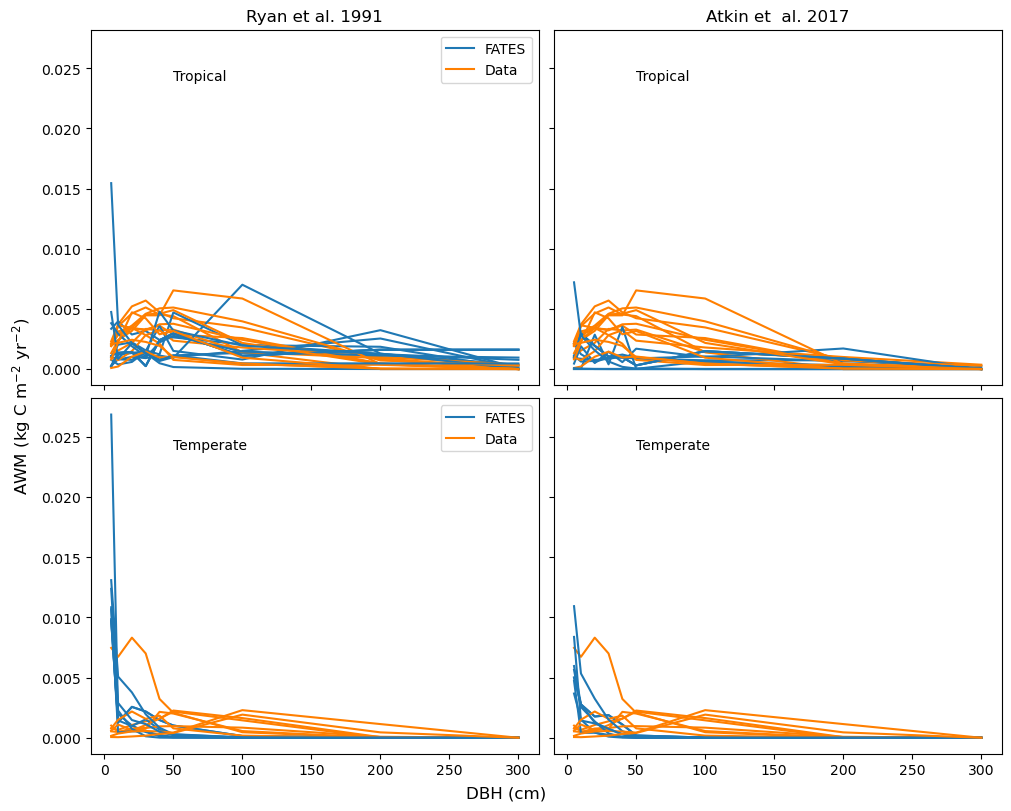

In [22]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(10,8),
                                                    constrained_layout=True, sharex=True, sharey=True)

for s in range(2,n_plots) :
   
    name = sites[s]
   # Plots
    # just keep the site of interest
    plotdata = data[data['site'] == name]
    AWM = np.array(plotdata[plotdata["variable"] == 'AWM']['total'])
    # If some of the size classes are missing add zeros
    if (not len(AWM) == 9) :
        zeros = np.repeat(np.array([0]), [9 - len(AWM)], axis=0)
        AWM = np.append(AWM,zeros)
       
    # FATES
    # szpf to size by pft
    awm_sz_by_pft_def = fa.scpf_to_scls_by_pft(
        fates_def.FATES_ABOVEGROUND_MORT_SZPF, fates_def)*86400*365
    # sum over pfts
    awm_sz_def = awm_sz_by_pft_def.sum(dim='fates_levpft')
    # last five years and extract lat and lon
    awm_def = awm_sz_def.isel(lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time') 

    # szpf to size by pft
    awm_sz_by_pft_new = fa.scpf_to_scls_by_pft(
        fates_new.FATES_ABOVEGROUND_MORT_SZPF, fates_new)*86400*365
    # sum over pfts
    awm_sz_new = awm_sz_by_pft_new.sum(dim='fates_levpft')
    # last five years and extract lat and lon
    awm_new = awm_sz_new.isel(lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time') 

    
    cohort_size_bins_ex = np.append(cohort_size_bins[1:],300)
    bins = np.diff(cohort_size_bins_ex)
    fates_awm_def = np.squeeze(awm_def[1:,]) 
    fates_awm_def = fates_awm_def/bins
    fates_awm_new = np.squeeze(awm_new[1:,]) 
    fates_awm_new = fates_awm_new/bins

    if name in tropical : 
    
        ### AGW Productivity
        if name in tropical[10]:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_awm_def, color=colormap[1], label = 'FATES')
            f2ax0.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax0.set_title('Ryan et al. 1991')    
            f2ax0.text(50, 0.024, 'Tropical', fontsize=10)
            f2ax1.plot(cohort_size_bins_ex[1:], fates_awm_new, color=colormap[1], label = 'FATES')
            f2ax1.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax1.set_title('Atkin et  al. 2017')
            f2ax1.text(50, 0.024, 'Tropical', fontsize=10)
        else:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_awm_def, color=colormap[1])
            f2ax0.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color=colormap[7])
            f2ax1.plot(cohort_size_bins_ex[1:], fates_awm_new, color=colormap[1])
            f2ax1.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color=colormap[7])
        
        
    else : 
        ### AGW Productivity
        if name in temperate[1]:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_awm_def, color=colormap[1], label = 'FATES')
            f2ax2.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax2.text(50, 0.024, 'Temperate', fontsize=10)
            f2ax3.plot(cohort_size_bins_ex[1:], fates_awm_new, color=colormap[1], label = 'FATES')
            f2ax3.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax3.text(50, 0.024, 'Temperate', fontsize=10)
        else:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_awm_def, color=colormap[1])
            f2ax2.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7])
            f2ax3.plot(cohort_size_bins_ex[1:], fates_awm_new, color=colormap[1])
            f2ax3.plot(cohort_size_bins_ex[1:], AWM * 1000 / 10000 / 2 / bins, color = colormap[7])
        
f2ax0.legend(prop={'size':10})
f2ax2.legend(prop={'size':10})

fig2.supxlabel(r'DBH (cm)')
fig2.supylabel(r'AWM (kg C m$^{-2}$ yr$^{-2}$)')

### AGB

Text(0.02, 0.5, 'AGB (kg C m$^{-2}$)')

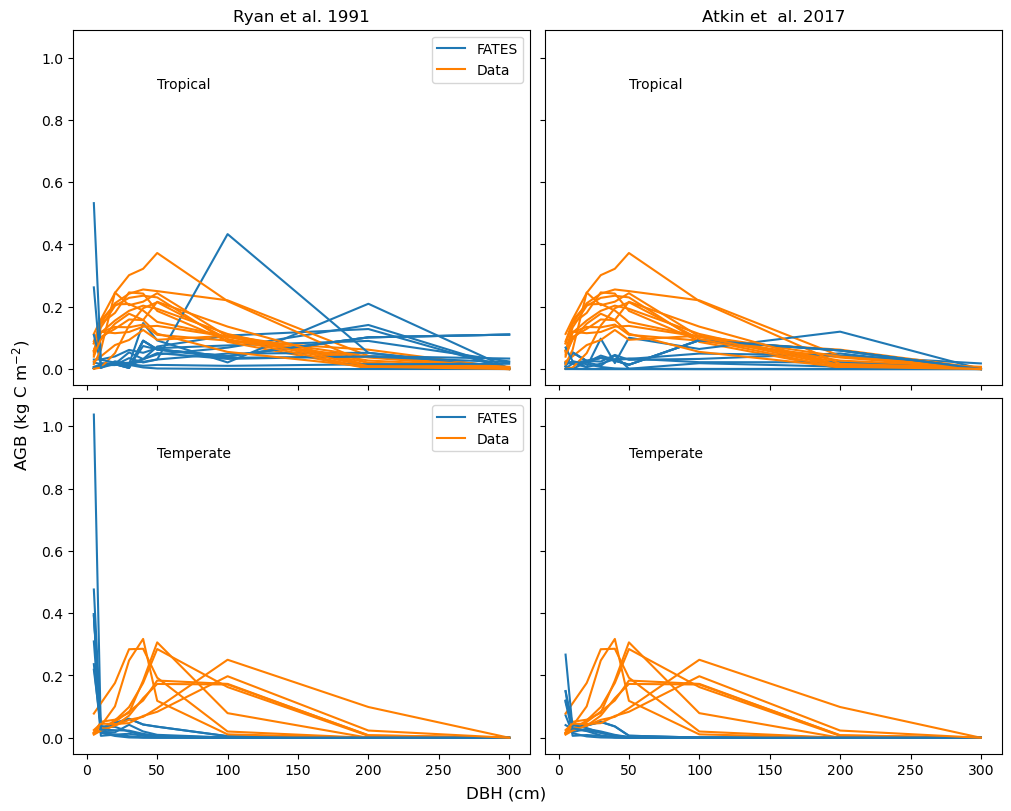

In [23]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(10,8),
                                                    constrained_layout=True, sharex=True, sharey=True)

for s in range(2,n_plots) :
   
    name = sites[s]
   # Plots
    # just keep the site of interest
    plotdata = data[data['site'] == name]
    AGB = np.array(plotdata[plotdata["variable"] == 'AGB']['total'])
    # If some of the size classes are missing add zeros
    if (not len(AGB) == 9) :
        zeros = np.repeat(np.array([0]), [9 - len(AGB)], axis=0)
        AGB = np.append(AGB,zeros)
       
    # FATES
    # AGB - by size
    agb_def = fates_def.FATES_VEGC_ABOVEGROUND_SZ.isel(
        lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time')
    agb_new = fates_new.FATES_VEGC_ABOVEGROUND_SZ.isel(
        lat = lat_ind[s], lon=lon_ind[s], time=slice(tave_start,tave_stop)).mean(dim='time')

    fates_agb_def = np.squeeze(agb_def[1:,]) 
    fates_agb_def = fates_agb_def/bins
    fates_agb_new = np.squeeze(agb_new[1:,]) 
    fates_agb_new = fates_agb_new/bins

    if name in tropical : 
    
        ### AGW Productivity
        if name in tropical[10]:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_agb_def, color=colormap[1], label = 'FATES')
            f2ax0.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax0.set_title('Ryan et al. 1991')    
            f2ax0.text(50, 0.9, 'Tropical', fontsize=10)
            f2ax1.plot(cohort_size_bins_ex[1:], fates_agb_new, color=colormap[1], label = 'FATES')
            f2ax1.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax1.set_title('Atkin et  al. 2017')
            f2ax1.text(50, 0.9, 'Tropical', fontsize=10)
        else:
            f2ax0.plot(cohort_size_bins_ex[1:], fates_agb_def, color=colormap[1])
            f2ax0.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color=colormap[7])
            f2ax1.plot(cohort_size_bins_ex[1:], fates_agb_new, color=colormap[1])
            f2ax1.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color=colormap[7])
        
        
    else : 
        ### AGW Productivity
        if name in temperate[1]:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_agb_def, color=colormap[1], label = 'FATES')
            f2ax2.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax2.text(50, 0.9, 'Temperate', fontsize=10)
            f2ax3.plot(cohort_size_bins_ex[1:], fates_agb_new, color=colormap[1], label = 'FATES')
            f2ax3.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7], label = 'Data')
            f2ax3.text(50, 0.9, 'Temperate', fontsize=10)
        else:
            f2ax2.plot(cohort_size_bins_ex[1:], fates_agb_def, color=colormap[1])
            f2ax2.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7])
            f2ax3.plot(cohort_size_bins_ex[1:], fates_agb_new, color=colormap[1])
            f2ax3.plot(cohort_size_bins_ex[1:], AGB * 1000 / 10000 / 2 / bins, color = colormap[7])
        
f2ax0.legend(prop={'size':10})
f2ax2.legend(prop={'size':10})

fig2.supxlabel(r'DBH (cm)')
fig2.supylabel(r'AGB (kg C m$^{-2}$)')